In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2, mutual_info_classif
from sklearn.metrics import *
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
from scipy import stats # probplot
from scipy.stats import norm
from sklearn.svm import SVC
from sklearn.utils import resample # permet de faire du rééchantillonage
import warnings

In [2]:
data_train = pd.read_csv("sets/train.csv")
trainset = data_train.copy()
data_test = pd.read_csv("sets/test.csv")
testset = data_test.copy()

pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings("ignore")

print(trainset.columns)
print(testset.columns)

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')
Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')


# **Preprocessing & Modelisation**
## **1. Data Preprocessing**
- ### Encodage : 

In [3]:
def encodage(df):
    print("Encodage")

    for col in df.select_dtypes("object"):
        df[col] = df[col].astype("category").cat.codes
        df[col] = df[col].replace(-1, np.nan)

    return df

- ### Selection des variables : 

In [4]:
def select_var(df):
    return df

- ### Imputation : 

In [5]:
def imputation(df):
    return df

- ### Feature Engineering : 

In [6]:
def feature_engineering(df):
    return df

- ### Transformation : 

In [7]:
def transformation(df):
    return df

- ### Train-Test split : 

In [8]:
trainset, testset = train_test_split(trainset, test_size=0.2, random_state=0)

- ### Preprocessing : 

In [9]:
def preprocessing(df):
    df = encodage(df)
    df = select_var(df)
    df = imputation(df)
    df = feature_engineering(df)
    df = transformation(df)

    X = df.drop("trip_duration", axis=1)
    y = df["trip_duration"]

    return X, y

X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)

Encodage
Encodage


- ### Transformation Inversion : 

In [10]:
def transformation_inversion(y_test, y_pred):
    return y_test, y_pred

## **2. Modelisation**
- ### Model : 

In [11]:
model = LGBMRegressor(random_state=0)

- ### Evaluation : 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1797
[LightGBM] [Info] Number of data points in the train set: 1166915, number of used features: 10
[LightGBM] [Info] Start training from score 958.686787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1797
[LightGBM] [Info] Number of data points in the train set: 87518, number of used features: 10
[LightGBM] [Info] Start training from score 952.581743
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1798
[LightGBM] [Info] Number of data points in the train set: 175037, number of used features: 10
[LightGBM] [Info] St

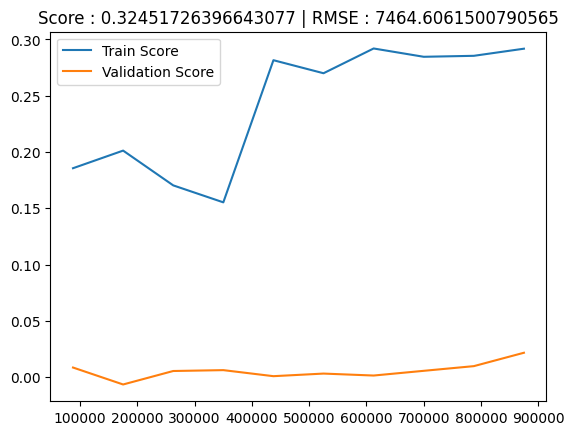

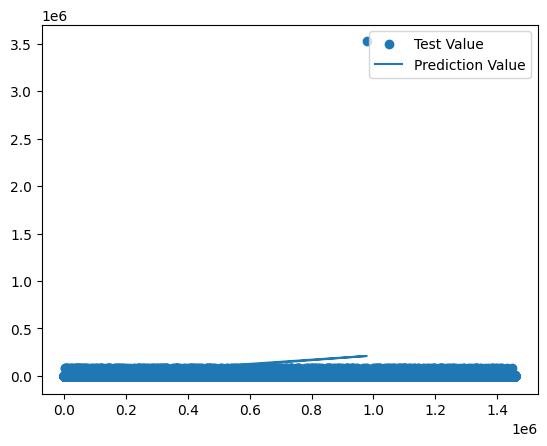

In [ ]:
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_test_inv, y_pred_inv = transformation_inversion(y_test, y_pred)

    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, train_sizes=np.linspace(0.1, 1, 10))

    plt.figure()
    plt.plot(N, train_score.mean(axis=1), label="Train Score")
    plt.plot(N, val_score.mean(axis=1), label="Validation Score")
    plt.title(f"Score : {model.score(X_train, y_train)} | RMSE : {root_mean_squared_error(y_test_inv, y_pred_inv)}")
    plt.legend()

    plt.figure()
    plt.scatter(X_test.index, y_test, label="Test Value")
    plt.plot(X_test.index, y_pred, label="Prediction Value", c="r")
    plt.legend()

evaluation(model)